<a href="https://colab.research.google.com/github/ropero99/TAM_2025_S2/blob/main/CaliforniaHousing_AnInv_IteG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación de librerías y preprocesamiento de datos

se importan librerías, se cargan los datos de California Housing, se escalan las variables (StandardScaler) y se añade una columna de unos (bias) a la matriz de características.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

# Cargar datos
housing = fetch_california_housing()
X = housing.data
y = housing.target
print(f"Dimensiones: X {X.shape}, y {y.shape}")

# Estandarizar los datos
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Añadir columna de unos para el término de bias
X_b = np.c_[np.ones(X_scaled.shape[0]), X_scaled]


Dimensiones: X (20640, 8), y (20640,)


# Solución analítica (método de la inversa)
mincua_reg_inversa implementa regresión Ridge usando la solución cerrada por inversa de matrices.Su propósito es encontrar los pesos óptimos del modelo de manera directa, sin iteraciones. alpha_inversa y predicciones y_pred_inversa.
* X: matriz de características (con bias incluido).
* y: vector de etiquetas o valores reales.
* λ: parámetro de regularización (evita sobreajuste).
* α: vector de coeficientes que aprende el modelo

* *XᵀX - calcula la matriz de correlaciones entre variables.*
* *XᵀX + λI - añade regularización para estabilizar la inversa y evitar* sobreajuste.
* *(XᵀX + λI)⁻¹ calcula la inversa.*
* *(XᵀX + λI)⁻¹Xᵀy obtiene los coeficientes óptimos α.*

In [2]:
def mincua_reg_inversa(X, y, lam=1e-3):
    """
    Regresión ridge usando el método de la inversa
    α = (XᵀX + λI)⁻¹Xᵀy

    si λ=0, la fórmula se reduce a la regresión lineal clásica (mínimos cuadrados): α = (XᵀX)⁻¹Xᵀy
    si λ>0 penalizamos coeficientes grandes, lo que mejora la estabilidad numérica y evita sobreajuste
    """
    identity_matrix = np.eye(X.shape[1])
    identity_matrix[0, 0] = 0  # No regularizar bias
    alpha = np.linalg.inv(X.T.dot(X) + lam * identity_matrix).dot(X.T).dot(y)
    return alpha

# Calcular coeficientes con inversa
alpha_inversa = mincua_reg_inversa(X_b, y_scaled)
print("Coeficientes (inversa):", alpha_inversa)

# Predicción
y_pred_inversa = X_b.dot(alpha_inversa)


Coeficientes (inversa): [-7.19736770e-15  7.18952249e-01  1.02910836e-01 -2.30106820e-01
  2.64917745e-01 -3.90230375e-03 -3.40803443e-02 -7.79844909e-01
 -7.54414680e-01]


# Método iterativo (gradiente descendente)
Implementa la regresión Ridge con gradiente descendente, que ajusta los coeficientes theta_gd de forma iterativa. También guarda la evolución del costo (cost_history).

In [7]:
def gradiente_descendente(X, y, learning_rate=0.01, n_iterations=1000, lam=1e-3):
    """
    Implementación de gradiente descendente para regresión ridge.

    Fórmulas:

    - Función de costo (Ridge Regression):
        J(θ) = (1/n) * Σ (yᵢ - ŷᵢ)²  +  (λ / (2n)) * Σ θⱼ²   para j >= 1
        con ŷ = Xθ

    - Gradiente:
        ∇J(θ) = (1/n) * ( Xᵀ(Xθ - y) + λθ )
        (no se regulariza el término bias θ₀)
    """
    n_samples, n_features = X.shape
    theta = np.zeros(n_features)  # Inicializar parámetros
    cost_history = []

    for iteration in range(n_iterations):
        # Predicción
        y_pred = X.dot(theta)
        error = y_pred - y

        # Gradiente con regularización
        gradient = (X.T.dot(error) + lam * theta) / n_samples
        gradient[0] = gradient[0] - (lam * theta[0]) / n_samples  # No regularizar bias

        # Actualización
        theta = theta - learning_rate * gradient # Ajusta los coeficientes en la dirección opuesta al gradiente

        # Costo (para monitorear)
        cost = np.mean(error**2) + (lam * np.sum(theta[1:]**2)) / (2 * n_samples) # error cuadratico medio (MSE) + Penalizacion L2
        cost_history.append(cost)

        #Devuelve los coeficientes finales theta.
        #Devuelve la lista de costos para graficar o analizar convergencia.
    return theta, cost_history

# Ejecutar gradiente descendente
theta_gd, cost_history = gradiente_descendente(X_b, y_scaled, learning_rate=0.1, n_iterations=2000, lam=1e-3)

print("Coeficientes (gradiente descendente):", theta_gd)

# Predicción
y_pred_gd = X_b.dot(theta_gd)

#y_pred_gd = X_b.dot(theta_gd) significa calcular las predicciones del modelo lineal
#multiplicando las características de entrada por los coeficientes aprendidos (incluyendo el bias).


Coeficientes (gradiente descendente): [-7.06398549e-15  7.18963802e-01  1.02912984e-01 -2.30128681e-01
  2.64935838e-01 -3.90167245e-03 -3.40807723e-02 -7.79818405e-01
 -7.54389523e-01]


# Visualización y comparación
Comparar coeficientes entre métodos.

Observar la convergencia del costo en gradiente descendente.

Comparar predicciones vs valores reales en ambos casos.


* Los coeficientes más altos (ej. índices 1, 7 y 8) indican características con mayor influencia en el precio de la vivienda.
* La solución analítica y la iterativa aprenden el mismo modelo.

* El gradiente descendente encontró una buena solución y el learning rate elegido (0.1) permitió una convergencia rápida y estable.


Ambos métodos son equivalentes.

La inversa es exacta pero puede ser costosa en datos grandes.

El gradiente descendente es aproximado pero más escalable.

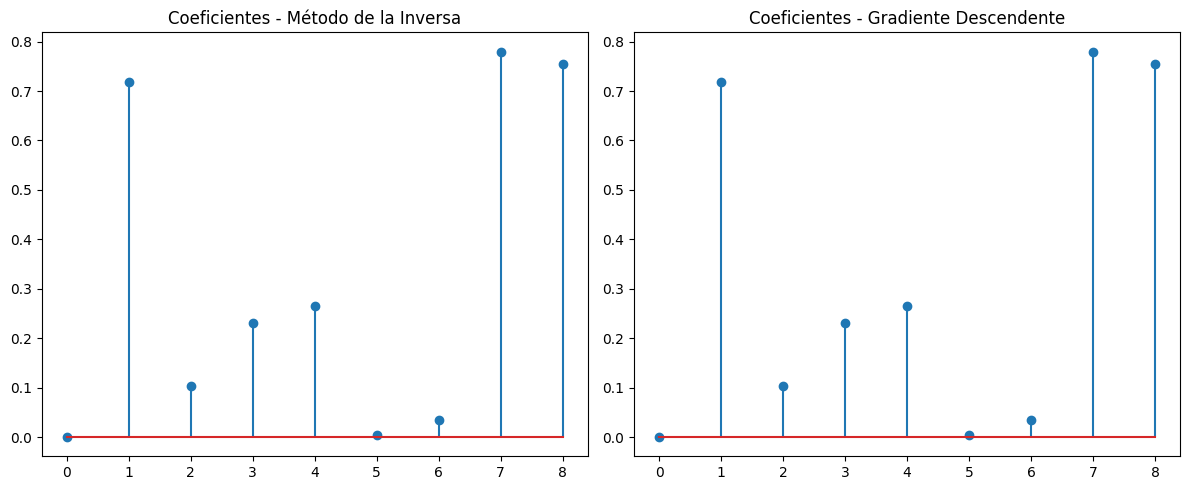

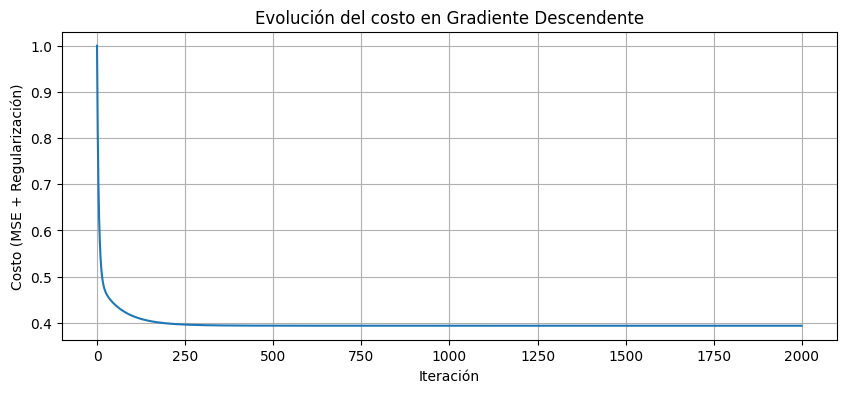

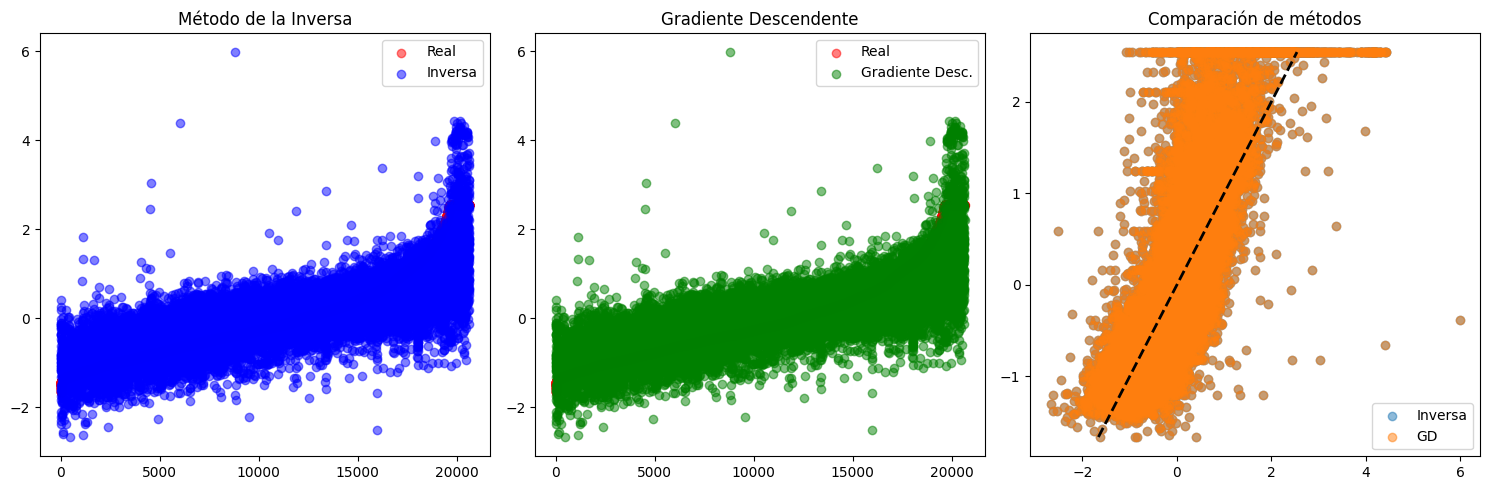

In [5]:
# Comparación de coeficientes
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.stem(np.arange(len(alpha_inversa)), np.abs(alpha_inversa))
plt.title('Coeficientes - Método de la Inversa')

plt.subplot(1, 2, 2)
plt.stem(np.arange(len(theta_gd)), np.abs(theta_gd))
plt.title('Coeficientes - Gradiente Descendente')
plt.tight_layout()
plt.show()

# Evolución del costo
plt.figure(figsize=(10, 4))
plt.plot(cost_history)
plt.title('Evolución del costo en Gradiente Descendente')
plt.xlabel('Iteración')
plt.ylabel('Costo (MSE + Regularización)')
plt.grid(True)
plt.show()

# Comparación de predicciones vs valores reales
ind_sorted = np.argsort(y_scaled)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(np.arange(len(y_scaled)), y_scaled[ind_sorted], c='red', alpha=0.5, label='Real')
plt.scatter(np.arange(len(y_pred_inversa)), y_pred_inversa[ind_sorted], c='blue', alpha=0.5, label='Inversa')
plt.legend(); plt.title('Método de la Inversa')

plt.subplot(1, 3, 2)
plt.scatter(np.arange(len(y_scaled)), y_scaled[ind_sorted], c='red', alpha=0.5, label='Real')
plt.scatter(np.arange(len(y_pred_gd)), y_pred_gd[ind_sorted], c='green', alpha=0.5, label='Gradiente Desc.')
plt.legend(); plt.title('Gradiente Descendente')

plt.subplot(1, 3, 3)
plt.scatter(y_pred_inversa, y_scaled, alpha=0.5, label='Inversa')
plt.scatter(y_pred_gd, y_scaled, alpha=0.5, label='GD')
plt.plot([y_scaled.min(), y_scaled.max()], [y_scaled.min(), y_scaled.max()], 'k--', lw=2)
plt.legend(); plt.title('Comparación de métodos')
plt.tight_layout()
plt.show()
